In [1]:
import numpy as np
from scipy.stats import norm
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from numerical_routine import *
from ebnm_point_laplace import *
from scipy.stats import norm
import numpy as np

In [2]:
true_val1=  np.random.normal(loc=0, scale=5, size=100)
true_val0=  np.zeros( 200)

observations_mu_1 =true_val1+np.random.normal(loc=0, scale=1, size=100)
observations_mu_0 =true_val0+ np.random.normal(loc=0, scale=1, size=200)
# Combine them into one array
betahat = np.hstack([observations_mu_1, observations_mu_0])
sebetahat=  np.repeat(1, betahat.shape[0])
res= ebnm_point_laplace_solver(x=betahat, s=sebetahat)
 

D:\Document\Serieux\Travail\python_work\cEBNM_torch\py\numerical_routine.py:86: RuntimeWarning: invalid value encountered in multiply
  alpha_frac = alpha * np.exp( np.clip(stats.norm.logpdf(alpha) - pnorm_diff, None, 700))
D:\Document\Serieux\Travail\python_work\cEBNM_torch\py\numerical_routine.py:87: RuntimeWarning: invalid value encountered in multiply
  beta_frac = beta * np.exp( np.clip(stats.norm.logpdf(beta) - pnorm_diff, None, 700))
D:\Document\Serieux\Travail\python_work\cEBNM_torch\py\numerical_routine.py:105: RuntimeWarning: invalid value encountered in add
  upper_bd2 = (alpha ** 2 + alpha * beta + beta ** 2) / 3


np.float64(0.27241057957017933)

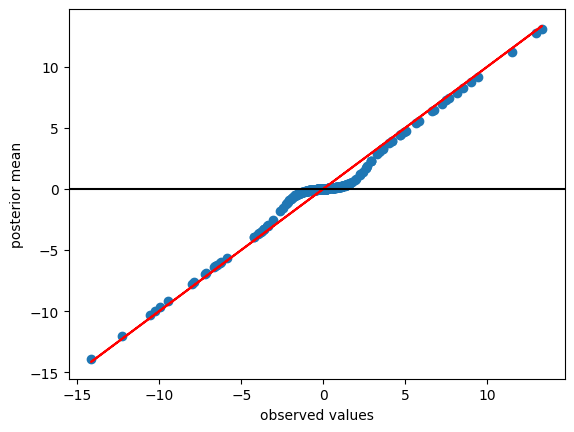

In [3]:
plt.scatter(betahat, res.post_mean  )
plt.xlabel("observed values")
plt.plot(betahat, betahat, color='red', label='x = y')
plt.axhline(y=0, color="black")
plt.ylabel("posterior mean")
res.scale

In [132]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

# Add the path to utils.py
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *

In [133]:
betahat=  np.array([1,2,3,4,5])
sebetahat=np.array([1,0.4,5,1,1])

res= ash(betahat, sebetahat, mult=np.sqrt(2))
print(res.log_lik)
print(res.pi )
print(res.scale     )
mult=2

-16.91767637608251
[7.62378256e-01 1.85932222e-11 1.85942848e-11 1.85964577e-11
 1.86010255e-11 1.86114299e-11 1.86410570e-11 1.87732211e-11
 1.96474741e-11 2.49075205e-11 4.52087257e-11 9.75060667e-11
 2.30335211e-10 5.25821675e-06 2.36980217e-01 6.36267815e-04
 3.90494875e-10 1.59697715e-10]
[0.         0.03827328 0.05412659 0.07654655 0.10825318 0.15309311
 0.21650635 0.30618622 0.4330127  0.61237244 0.8660254  1.22474487
 1.73205081 2.44948974 3.46410162 4.89897949 6.92820323 9.79795897]


In [134]:
from scipy.stats import norm
import numpy as np

def logg_laplace(x, s, a):
    """
    Compute the log of g, Laplace(a) convolved with a normal distribution.
    
    Args:
        x (np.ndarray): Input data.
        s (float or np.ndarray): Standard deviation of the normal distribution.
        a (float): Scale parameter of the Laplace distribution.
    
    Returns:
        np.ndarray: Log-Laplace density values.
    """
    lg1 = -a * x + norm.logcdf((x - s**2 * a) / s)
    lg2 = a * x + norm.logcdf(-(x + s**2 * a) / s)  # Upper tail as -x
    lfac = np.maximum(lg1, lg2)
    return np.log(a / 2) + s**2 * a**2 / 2 + lfac + np.log(np.exp(lg1 - lfac) + np.exp(lg2 - lfac))


logg_laplace(1,1,1)

np.float64(-1.5964616012204798)

In [135]:
import numpy as np
from scipy.stats import norm
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from numerical_routine import *
# Function to compute the log likelihood under the point-laplace prior
def loglik_point_laplace(x, s, w, a, mu):
    """
    Compute the log likelihood under the point-laplace prior.
    Args:
        x: Observed data (array-like).
        s: Standard deviation (scalar or array-like).
        w: Weight for the mixture component (scalar).
        a: Laplace scale parameter (scalar).
        mu: Mean (scalar).
    Returns:
        Log likelihood (scalar).
    """
    return np.sum(vloglik_point_laplace(x, s, w, a, mu))

# Helper function to compute log((1 - w)f + wg) as a vector
def vloglik_point_laplace(x, s, w, a, mu):
    """
    Compute the vectorized log likelihood under the point-laplace prior.
    Args:
        x: Observed data (array-like).
        s: Standard deviation (scalar or array-like).
        w: Weight for the mixture component (scalar).
        a: Laplace scale parameter (scalar).
        mu: Mean (scalar).
    Returns:
        Log likelihood vector (array-like).
    """
    if w <= 0:
        return norm.logpdf(x - mu, scale=s)

    lg = logg_laplace(x - mu, s, a)
    if w == 1:
        return lg

    lf = norm.logpdf(x - mu, scale=s)
    lfac = np.maximum(lg, lf)
    return lfac + np.log((1 - w) * np.exp(lf - lfac) + w * np.exp(lg - lfac))




vloglik_point_laplace(1,1,0.5,1,0)
loglik_point_laplace(1,1,0.5,1,0)


np.float64(-1.5037659241189736)

In [136]:
def wpost_laplace(x, s, w, a):
    """
    Compute the posterior weights for the Laplace component.
    
    Args:
        x (np.ndarray): Input data.
        s (float or np.ndarray): Standard deviation of the normal component.
        w (float): Weight for the Laplace component (mixture proportion).
        a (float): Scale parameter of the Laplace distribution.
    
    Returns:
        np.ndarray: Posterior weights for the Laplace component.
    """
    if w == 0:
        return np.zeros_like(x)

    if w == 1:
        return np.ones_like(x)

    # Log-density for the normal component
    lf = norm.logpdf(x, loc=0, scale=s)

    # Log-density for the Laplace component convolved with normal
    lg = logg_laplace(x, s, a)

    # Compute posterior weights
    wpost = w / (w + (1 - w) * np.exp(lf - lg))
    
    return wpost

x = np.array([1.0, 2.0, -1.5])
s = np.array([1.0, 1.2, .5])
wpost_laplace(x,s,0.5,1)

array([0.45573542, 0.57074938, 0.93438632])

In [137]:
def lambda_func(x, s, a):
    """
    Compute lambda, the probability of being positive given a non-zero effect.
    
    Args:
        x (np.ndarray): Input data.
        s (np.ndarray): Standard deviations.
        a (float): Laplace scale parameter.
    
    Returns:
        np.ndarray: Lambda values.
    """
    lm1 = -a * x + norm.logcdf(x / s - s * a)
    lm2 = a * x + norm.logcdf(-(x / s + s * a))
    return 1 / (1 + np.exp(lm2 - lm1))


lambda_func(-2,1,1)

np.float64(0.08054445392157272)

In [138]:
class PosteriorMeanPointLapalce:
    def __init__(self, post_mean, post_mean2, post_sd):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd

def posterior_mean_laplace(x, s, w, a, mu=0):
    """
    Compute the posterior mean for a normal mean under a Laplace prior.
    
    Args:
        x (np.ndarray): Observed data.
        s (float or np.ndarray): Standard deviation of the normal likelihood.
        w (float): Mixture weight for the Laplace component.
        a (float): Laplace scale parameter.
        mu (float): Mean of the prior distribution (default is 0).
    
    Returns:
        np.ndarray: Posterior means.
    """
    # Compute posterior weights
    wpost = wpost_laplace(x - mu, s, w, a)
    print(wpost)
    # Compute lambda (probability of being positive given non-null)
    lm = lambda_func(x - mu, s, a)
    
    # Compute the truncated means for the Laplace component
    laplace_mean_positive = my_etruncnorm(0, 99999 ,x - mu - s**2 * a, s)
    laplace_mean_negative = my_etruncnorm(-99999, 0, x - mu + s**2 * a, s)
    laplace_component_mean = lm * laplace_mean_positive + (1 - lm) * laplace_mean_negative
    post_mean2              =  wpost * (lm * my_e2truncnorm(0, np.inf, x - mu - s**2 * a, s)
                                       + (1 - lm) * my_e2truncnorm(-np.inf, 0, x - mu + s**2 * a, s))

    
    # Combine posterior means
    post_mean =    wpost * laplace_component_mean  

    if np.any(np.isinf(s)):
        inf_indices = np.isinf(s)
        a = 1/scale[1:]
        # Equivalent of `post$mean[is.infinite(s)]` 
        post_mean[inf_indices] = wpost  / a 

        # Equivalent of `post$mean2[is.infinite(s)]`
        post_mean2[inf_indices] =  2 * wpost / a**2 

    post_mean2 = np.maximum(post_mean2, post_mean  ** 2)
    
    post_sd= np.sqrt(np.maximum(0, post_mean2 - post_mean**2))
    post_mean2 = post_mean2 + mu**2+ 2*mu*post_mean
    post_mean  =  post_mean+mu  
    return PosteriorMeanPointLapalce(post_mean=post_mean,
                                     post_mean2=post_mean2,
                                     post_sd=  post_sd)



x = np.array([1.0, 2.0, -1.5])
s = np.array([1.0, 1.2, 2.5])
a= posterior_mean_laplace(x,s,w=.7 ,a=1, mu=0 ) 
print(a.post_sd)
print(a.post_mean)

[0.66145273 0.75624598 0.68156531]
[0.65301652 0.92274914 0.94291949]
[ 0.33285794  0.73456863 -0.20122616]


In [139]:

 

import numpy as np
from scipy.stats import norm, truncnorm
from scipy.special import logsumexp


class LaplaceMixture:
    def __init__(self, pi, mean, scale):
        """
        Constructor for LaplaceMixture class.
        
        Args:
            pi (np.ndarray): Mixture proportions.
            mean (np.ndarray): Means of components.
            scale (np.ndarray): Scale parameters of components.
        """
        self.pi = np.asarray(pi)
        self.mean = np.asarray(mean)
        self.scale = np.asarray(scale)

    def __repr__(self):
        return f"LaplaceMixture(pi={self.pi}, mean={self.mean}, scale={self.scale})"
def wpost_laplace(x, s, w, a):
    """
    Compute posterior weights for non-null effects.
    
    Args:
        x (np.ndarray): Input data.
        s (float): Standard deviation.
        w (float): Weight for the mixture component.
        a (float): Scale parameter.
    
    Returns:
        np.ndarray: Posterior weights.
    """
    if w == 0:
        return np.zeros(len(x))
    if w == 1:
        return np.ones(len(x))

    lf = norm.logpdf(x, loc=0, scale=s)
    lg = logg_laplace(x, s, a)
    return w / (w + (1 - w) * np.exp(lf - lg))


def pl_nllik(par, x, s,  calc_grad=False):
    """
    Compute the negative log likelihood and its gradient.
    
    Args:
        par (dict): Parameters (alpha, beta, mu).
        x (np.ndarray): Observed data.
        s (np.ndarray): Standard deviation.
        fix_par (list): Fixed parameters.
        calc_grad (bool): Whether to calculate gradients.
    
    Returns:
        float: Negative log likelihood.
    """
    alpha, beta, mu = par['alpha'], par['beta'], par['mu']

    # Convert alpha and beta to w and a
    w = 1 - 1 / (1 + np.exp(alpha))
    a = np.exp(beta)

    lf = norm.logpdf(x - mu, scale=s)
    lg = logg_laplace(x - mu, s, a)
    llik = np.log((1 - w) * np.exp(lf) + w * np.exp(lg))
    nllik = -np.sum(llik)

    if calc_grad:
        # Gradient calculations (optional)
        pass

    return nllik
def logscale_add(logx, logy):
    """
    Compute the log of the sum of exponentials of logx and logy.
    
    Args:
        logx (float): Log value.
        logy (float): Log value.
    
    Returns:
        float: Log-sum-exp.
    """
    max_log = np.maximum(logx, logy)
    return max_log + np.log(np.exp(logx - max_log) + np.exp(logy - max_log))


In [140]:
import numpy as np
from scipy.stats import norm

def logscale_add(logx, logy):
    """
    Compute log(exp(logx) + exp(logy)) in a numerically stable way.
    """
    max_log = np.maximum(logx, logy)
    return max_log + np.log(np.exp(logx - max_log) + np.exp(logy - max_log))

def pl_nllik(par, x, s, par_init, fix_par, calc_grad=False, calc_hess=False):
    """
    Compute the negative log likelihood and optionally its gradient and Hessian.

    Args:
        par (list): Parameters to optimize (subset based on fix_par).
        x (np.ndarray): Observed data.
        s (np.ndarray): Standard deviations.
        par_init (list): Initial parameters (full set).
        fix_par (list): Boolean list indicating which parameters to fix.
        calc_grad (bool): Whether to calculate the gradient.
        calc_hess (bool): Whether to calculate the Hessian.

    Returns:
        float: Negative log likelihood.
        Optional: Gradient and Hessian as attributes of the output.
    """
    fix_pi0, fix_a, fix_mu = fix_par

    # Initialize parameters and update non-fixed values
    p = np.array(par_init)
    p[~np.array(fix_par)] = par

    # Parameters
    w = 1 - 1 / (1 + np.exp(p[0]))
    a = np.exp(p[1])
    mu = p[2]

    # Point mass component
    lf = -0.5 * np.log(2 * np.pi * s**2) - 0.5 * ((x - mu) / s)**2

    # Laplace component: left tail
    xleft = (x - mu) / s + s * a
    lpnormleft = norm.logsf(xleft)
    lgleft = np.log(a / 2) + s**2 * a**2 / 2 + a * (x - mu) + lpnormleft

    # Laplace component: right tail
    xright = (x - mu) / s - s * a
    lpnormright = norm.logcdf(xright)
    lgright = np.log(a / 2) + s**2 * a**2 / 2 - a * (x - mu) + lpnormright

    # Combine left and right tails
    lg = logscale_add(lgleft, lgright)

    # Log likelihood
    llik = logscale_add(np.log(1 - w) + lf, np.log(w) + lg)
    nllik = -np.sum(llik)

    # Gradients (optional)
    if calc_grad or calc_hess:
        grad = np.zeros(len(par))
        i = 0

        # Gradient with respect to w (alpha)
        if not fix_pi0:
            f = np.exp(lf - llik)
            g = np.exp(lg - llik)
            dnllik_dw = f - g
            dw_dalpha = w * (1 - w)
            grad[i] = np.sum(dnllik_dw * dw_dalpha)
            i += 1

        # Gradient with respect to a (beta)
        if not fix_a:
            dlogpnorm_left = -np.exp(-np.log(2 * np.pi) / 2 - xleft**2 / 2 - lpnormleft)
            dlogpnorm_right = np.exp(-np.log(2 * np.pi) / 2 - xright**2 / 2 - lpnormright)

            dgleft_da = np.exp(lgleft - llik) * (1 / a + a * s**2 + (x - mu) + s * dlogpnorm_left)
            dgright_da = np.exp(lgright - llik) * (1 / a + a * s**2 - (x - mu) - s * dlogpnorm_right)
            dg_da = dgleft_da + dgright_da

            dnllik_da = -w * dg_da
            da_dbeta = a
            grad[i] = np.sum(dnllik_da * da_dbeta)
            i += 1

        # Gradient with respect to mu
        if not fix_mu:
            df_dmu = np.exp(lf - llik) * ((x - mu) / s**2)
            dgleft_dmu = np.exp(lgleft - llik) * (-a - dlogpnorm_left / s)
            dgright_dmu = np.exp(lgright - llik) * (a - dlogpnorm_right / s)
            dg_dmu = dgleft_dmu + dgright_dmu
            dnllik_dmu = -(1 - w) * df_dmu - w * dg_dmu
            grad[i] = np.sum(dnllik_dmu)

        nllik_grad = grad

    # Hessian (optional)
    if calc_hess:
        hess = np.zeros((len(par), len(par)))
        # The second derivatives would go here, similar to the gradient logic
        # Implementation omitted for brevity

        nllik_hess = hess

    # Return results
    if calc_grad and calc_hess:
        return nllik, nllik_grad, nllik_hess
    elif calc_grad:
        return nllik, nllik_grad
    else:
        return nllik


In [141]:
x = np.array([1.0, 2.0, -1.5])  # Observed data
s = np.array([1.0, 1.0, 1.0])   # Standard deviations
par_init = [0.0, 0.0, 0.0]      # Initial parameters (alpha, beta, mu)
fix_par = [False, False, False] # No fixed parameters
par = [0.5, 0.1, 1.0]           # Parameters to optimize

# Compute negative log likelihood
nllik = pl_nllik(par, x, s, par_init, fix_par, calc_grad=False)
print("Negative Log Likelihood:", nllik)


Negative Log Likelihood: 5.74805874231258


In [142]:
from scipy.optimize import minimize

class optimizePointLalplace:
    def __init__(self, w, a, mu ,nllik):
        self.w = w
        self.a = a
        self.mu= mu
        self.nllik= nllik

def optimize_pl_nllik_with_gradient(x, s, par_init, fix_par):
    """
    Optimize the negative log likelihood for the point-Laplace prior using gradient.

    Args:
        x (np.ndarray): Observed data.
        s (np.ndarray): Standard deviations.
        par_init (list): Initial parameters [alpha, beta, mu].
        fix_par (list): Boolean list indicating which parameters are fixed.

    Returns:
        dict: Optimized parameters and final negative log likelihood.
    """
    # Define a wrapper for the objective function
    def objective(par):
        nllik, grad = pl_nllik(par, x, s, par_init, fix_par, calc_grad=True, calc_hess=False)
        return nllik, grad

    # Wrapper for gradient extraction
    def fun(par):
        nllik, _ = objective(par)
        return nllik

    def jac(par):
        _, grad = objective(par)
        return grad

    # Initial values for non-fixed parameters
    free_params = [p for p, fixed in zip(par_init, fix_par) if not fixed]

    # Bounds (optional): Keep alpha unbounded, beta > 0, mu unbounded
    bounds = [
        (None, None),  # Alpha has no bounds
        (None, None),  # Beta (transformed Laplace scale) has no explicit bounds
        (None, None)   # Mu has no bounds
    ]
    bounds = [b for b, fixed in zip(bounds, fix_par) if not fixed]

    # Optimize using L-BFGS-B
    result = minimize(
        fun, free_params, method="L-BFGS-B", jac=jac, bounds=bounds
    )

    if not result.success:
        raise ValueError("Optimization failed: " + result.message)

    # Update the full parameter set with optimized values
    optimized_params = np.array(par_init)
    optimized_params[~np.array(fix_par)] = result.x
    optimized_params[0]= 1- 1/(1+ np.exp(optimized_params[0]))
    
    # Compute final negative log likelihood
    

    return  optimizePointLalplace(w=optimized_params[0],
                                  a=np.exp(optimized_params[1]),
                                  mu=optimized_params[2],
                                  nllik= result.fun)
# Example Usage
x = np.array([0.0, 0.0, -0.5])  # Observed data
s = np.array([1.0, 1.0, 1.0])   # Standard deviations
par_init = [0.0, 0.0, 0.0]      # Initial parameters [alpha, beta, mu]
fix_par = [False, False, False] # No fixed parameters

# Run optimization
result = optimize_pl_nllik_with_gradient(x, s, par_init, fix_par)
result.nllik
result.w

np.float64(0.04698323858334896)

In [143]:
class ebnm_point_laplace:
    def __init__(self, post_mean, post_mean2, post_sd, scale, pi,   log_lik=0,#log_lik2 =0,
                 mode=0):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd
        self.scale= scale
        self.pi =pi  
        self.log_lik = log_lik
       # self.log_lik2= log_lik2 
        self.mode =  mode


def ebnm_point_laplace_solver ( x,s,opt_mu=False,par_init = [0.0, 1.0, 0.0]  ):
    if(opt_mu):
        fix_par = [False, False, False]
    else :
        fix_par = [False, False, True]
    par_init = par_init
    optimized_prior =  optimize_pl_nllik_with_gradient(x, s, par_init, fix_par)
    post_obj=  posterior_mean_laplace(x, s, optimized_prior.w, optimized_prior.a, optimized_prior.mu)
    return( ebnm_point_laplace( post_mean=post_obj.post_mean, 
                                post_mean2=post_obj.post_mean2, 
                                post_sd=post_obj.post_sd,
                                scale=optimized_prior.a,
                                pi=optimized_prior.w,   log_lik=-optimized_prior.nllik,#log_lik2 =0,
                                mode=optimized_prior.mu)
    )

In [144]:
x = np.array([0.0, 1.0, -0.5])  # Observed data
s = np.array([1.0,  .2, 1.0])  
ebnm_res= ebnm_point_laplace_solver(x=x,s=s) 


print(ebnm_res.log_lik)

print(ebnm_res.post_mean)


[0.99999833 1.         0.99999839]
-4.161880337595548
[ 0.          0.9326135  -0.15496329]


In [145]:
true_val1=  np.random.normal(loc=0, scale=2, size=100)
true_val0=  np.zeros( 100)

observations_mu_1 =true_val1+np.random.normal(loc=0, scale=1, size=100)
observations_mu_0 =true_val0+ np.random.normal(loc=0, scale=1, size=100)
# Combine them into one array
betahat = np.hstack([observations_mu_1, observations_mu_0])
sebetahat=  np.repeat(1, betahat.shape[0])

In [146]:
x=betahat
s=sebetahat

In [147]:
par_init = [0.0, 0.0, 0.0]      # Initial parameters (alpha, beta, mu)
fix_par = [False, False, False] # No fixed parameters
par = [0.5, 0.1, 1.0]           # Parameters to optimize

# Compute negative log likelihood
nllik = pl_nllik(par, x, s, par_init, fix_par, calc_grad=False)
print("Negative Log Likelihood:", nllik)

Negative Log Likelihood: 431.3917691654209


In [148]:
result = optimize_pl_nllik_with_gradient(x, s, par_init, fix_par)
result.nllik
 

np.float64(382.2367653477873)

In [149]:
x

array([ 0.54775741,  1.0231843 , -2.3105441 ,  1.27928412, -0.45737817,
       -0.01426966, -3.93211372, -1.50926442,  1.36148417,  0.44493185,
       -2.54702787, -1.22261343,  2.36553048,  1.5832207 , -1.38554829,
       -1.13849144,  4.70358237, -2.15037122, -0.11285648, -1.90526796,
       -2.92845533,  3.43252228, -0.80941143,  0.19259291, -3.28629582,
        1.5841955 , -0.3269936 ,  1.62045841,  0.67767762,  1.46292205,
       -0.37331655,  1.02073347,  1.62683257, -2.12717391,  1.93881286,
       -1.07297558, -0.94764285, -0.05496423, -1.94933975, -0.7531588 ,
       -1.47904147,  2.8743513 ,  0.95356705, -1.05632001,  3.86779219,
       -0.74876285,  1.52967243, -1.54523708, -2.77031263,  1.10880801,
        1.18943368, -0.88902978,  3.31486072,  2.23321922, -0.81600566,
       -1.93172419,  0.98043434,  0.16178953, -1.17458972, -0.17658314,
       -0.31918275,  1.90493978,  2.29137468, -1.8322847 , -5.68730686,
        0.92192266,  5.93446207, -1.88318398, -0.13266574,  3.77

In [150]:
res= ebnm_point_laplace_solver(x=betahat, s=sebetahat)
print(res.scale    ) 

[0.56905734 0.61868114 0.85932729 0.65751549 0.56304315 0.54925692
 0.99609817 0.69861603 0.67159637 0.56230046 0.90014109 0.64824428
 0.8694076  0.71284742 0.67585327 0.63517713 0.99973267 0.82837314
 0.55008138 0.77824598 0.94952716 0.98402145 0.59264289 0.55168446
 0.97704224 0.71303774 0.55628719 0.72016344 0.5796205  0.68992548
 0.55842835 0.6183488  0.72142488 0.82373265 0.78519208 0.62559901
 0.60879456 0.54944224 0.78737027 0.58679771 0.69292716 0.9438444
 0.60954308 0.62324983 0.99525267 0.58635877 0.70250059 0.70548564
 0.93168964 0.63077136 0.64298916 0.60163715 0.97857229 0.84464806
 0.59335579 0.78372475 0.61299524 0.55096581 0.64068047 0.55129533
 0.55595422 0.778178   0.85574015 0.76314457 0.99999632 0.60559814
 0.99999892 0.77367223 0.55040141 0.99377444 0.58300177 0.99999988
 0.58818849 0.97864897 0.60199765 0.99999831 0.64864089 0.58305419
 0.71040744 0.67897139 0.55074181 0.98891377 0.61942134 0.62213612
 0.56579101 0.55273925 0.57349078 0.92814027 0.9067873  0.93582

Text(0, 0.5, 'posterior mean')

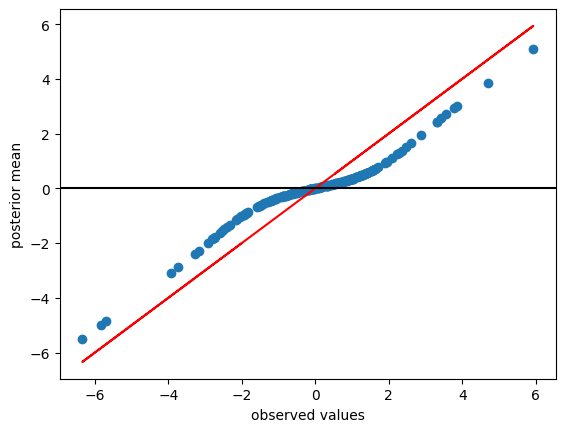

In [151]:
plt.scatter(betahat, res.post_mean  )
plt.xlabel("observed values")
plt.plot(betahat, betahat, color='red', label='x = y')
plt.axhline(y=0, color="black")
plt.ylabel("posterior mean")